In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

<div style="text-align: center;">
    <h1 style="font-size: 36px; color: #000000; font-weight: bold;">
        Relatório Parcial: Comparação entre Heurísticas Gulosa e Aleatória<br>para Programação de Filmes
    </h1>
    <h2 style="font-size: 24px; color: #000000; font-weight: bold;">
        Autor: Beni Kracochansky
    </h2>
    <hr style="width: 50%; border: 1px solid #000000;">
</div>

## Implementação das Heurísticas

### Heurística Gulosa

A heurística gulosa seleciona os filmes com base no horário de término, de forma crescente, escolhendo os filmes que começam primeiro e não conflitam com os filmes já escolhidos, além de verificar se há vagas disponíveis na categoria do filme.

1. Tratamento do input:
    * O arquivo de input contém o número de filmes, as categorias e as informações de cada filme (hora de início, hora de fim e categoria).
    * O algoritmo lê o arquivo e armazena as informações em estruturas de dados adequadas.

2. Lógica do output:
    * O algoritmo ordena os filmes com base no horário de término, de forma crescente.
    * A heurística seleciona os filmes nessa ordem, garantindo que não haja conflitos de horário e que haja vagas disponíveis na categoria do filme.
    * O output contém a quantidade máxima de filmes que podem ser assistidos de acordo com as restrições de horários e número máximo por categoria.

3. Invariantes:
    * A lista de filmes é sempre ordenada com base no horário de término, de forma crescente.
    * Não há conflitos de horário entre os filmes selecionados.
    * O número máximo de filmes por categoria é respeitado.

```c++ 
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>
#include <random>
#include <ctime>

// Define the Movie structure with start, end, category, and index fields
struct Movie {
    int start, end, category, index;
};

// Function prototypes
bool compareMovies(const Movie &a, const Movie &b);
bool timeOverlap(int start1, int end1, int start2, int end2);
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory);

// Compare function for sorting movies by end time, and start time in case of a tie
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}


// Function to check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    if (!((start1 >= end2) || (end1 <= start2))) {
        return true;
    }
    else {
        return false;
    }
}


// Function to read movies from input file and return a vector of Movie structures
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory) {
    std::ifstream inputFile(filename);

    // Read the number of movies and categories from the input file
    inputFile >> N >> M;

    // Resize the maxMoviesPerCategory vector according to the number of categories
    maxMoviesPerCategory.resize(M);

    // Read the maximum number of movies per category
    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    // Initialize the movies vector with the number of movies
    std::vector<Movie> movies(N);

    // Read the movie information
    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        if (movies[i].end < movies[i].start) {
            movies[i].end += 24;
        }
        movies[i].index = i; // Set the index of the movie
    }

    // Close the input file
    inputFile.close();
    return movies;
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        std::cerr << "Usage: " << argv[0] << " <input_file>" << std::endl;
        return 1;
    }

    std::string input_file = argv[1];
    int N, M;
    std::vector<int> maxMoviesPerCategory;

    // Passe o nome do arquivo de input para a função readMovies
    std::vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);
    

    // Sort the movies by end time, and start time in case of a tie
    std::sort(movies.begin(), movies.end(), compareMovies);

    // Initialize the chosenMoviesPerCategory vector
    std::vector<int> chosenMoviesPerCategory(M, 0);
    std::vector<Movie> chosenMovies;
    int moviesWatched = 0;

    // Initialize a vector to track which movies have been selected
    std::vector<bool> movieSelected(N, false);

    // Initialize the random number generator
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<double> distribution(0.0, 1.0);
    gen.seed(rd() + time(0));

    // Start the timer
    auto startTime = std::chrono::steady_clock::now();

    // Iterate over the sorted movies
    for (const Movie &movie : movies) {

        double randomValue = distribution(gen);
        if (randomValue <= 0.25) {

            // Make another alearization to find an alternative movie
            std::uniform_int_distribution<int> distribution2(movie.index, N - 1);
            bool conflict2 = false;
                
            int randomValue2 = distribution2(gen);

            if (movies[randomValue2].start == movies[randomValue2].end) {
                continue;
            }

            for (auto& chosen_movie: chosenMovies){
                // verify if movies is valid to be selected compared to movie
                if (!(!(timeOverlap(movies[randomValue2].start, movies[randomValue2].end, chosen_movie.start, chosen_movie.end)) && (chosenMoviesPerCategory[movies[randomValue2].category - 1] < maxMoviesPerCategory[movies[randomValue2].category - 1]))){
                    conflict2=true; 
                }
            }

            if (!conflict2){
                chosenMoviesPerCategory[movies[randomValue2].category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movies[randomValue2]);
                movieSelected[randomValue2] = true; // Mark the alternative movie as selected 
            } else{
                // std::cout << "No alternative movie found" << std::endl;
            }
        }

        if (movie.start == movie.end) {
            continue;
        }

        // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
        if (!movieSelected[movie.index] && movie.end > movie.start && (chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1])) {
            bool conflict = false;

            // Check for conflicts with other chosen movies
            for (const Movie &chosenMovie : chosenMovies) {
                if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
                    conflict = true;
                }
            }

            // Check for conflicts with other chosen movies

            if (!conflict) {
                chosenMoviesPerCategory[movie.category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movie);
                movieSelected[movie.index] = true; // Mark the alternative movie as selected
            } else {
                // std::cout << "No alternative movie found 2" << std::endl;
            }
    
        }
    }    

    // Stop the timer
    auto endTime = std::chrono::steady_clock::now();

    // Calculate the time elapsed during algorithm execution
    double duration = std::chrono::duration_cast<std::chrono::microseconds>(endTime - startTime).count();

    // Sort the chosenMovies vector by end time, and start time in case of a tie
    std::sort(chosenMovies.begin(), chosenMovies.end(), compareMovies);

    // Print the number of movies watched
    std::cout << "Movies watched: " << moviesWatched << std::endl;

    // Print the start and end times, and category of the selected movies
    for (const Movie &movie : chosenMovies) {
        std::cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << std::endl;
    }

    // Print the time elapsed during the aleatory algorithm execution
    std::cout << "Time elapsed during the aleatory algorithm: " << duration << " microseconds" << std::endl;
}
```

### Heurística Gulosa Adaptada com Aleatoriedade

A heurística gulosa adaptada com aleatoriedade modifica a heurística gulosa original, adicionando um elemento de aleatoriedade na seleção dos filmes. Ao longo da seleção, há 25% de chance de escolher outro filme qualquer que respeite o horário, adicionando um pouco mais de exploration.

1. Tratamento do input:
    * O arquivo de input contém o número de filmes, as categorias e as informações de cada filme (hora de início, hora de fim e categoria).
    * O algoritmo lê o arquivo e armazena as informações em estruturas de dados adequadas.

2. Lógica do output:
    * O algoritmo ordena os filmes com base no horário de término, de forma crescente.
    * A heurística seleciona os filmes nessa ordem, mas com 25% de chance de escolher outro filme qualquer que respeite o horário e as restrições de categoria.
    * O output contém a quantidade máxima de filmes que podem ser assistidos de acordo com as restrições de horários e número máximo por categoria.

3. Invariantes:
    * A lista de filmes é sempre ordenada com base no horário de término, de forma crescente.
    * Não há conflitos de horário entre os filmes selecionados.
    * O número máximo de filmes por categoria é respeitado.

```c++
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>

// Define the Movie structure with start, end, and category fields
struct Movie {
    int start, end, category;
};

// Function prototypes
bool compareMovies(const Movie &a, const Movie &b);
bool timeOverlap(int start1, int end1, int start2, int end2);
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory);

// Compare function for sorting movies by end time, and start time in case of a tie
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}

// Function to adjust the end time of a movie if it crosses the day boundary
int adjustEndTime(int endTime) {
    if (endTime == 0) {
        return 24;
    }
    return endTime;
}

// Function to check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    end1 = adjustEndTime(end1);
    end2 = adjustEndTime(end2);

    return start1 < end2 && start2 < end1;
}

// Function to read movies from input file and return a vector of Movie structures
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory) {
    std::ifstream inputFile(filename);

    // Read the number of movies and categories from the input file
    inputFile >> N >> M;

    // Resize the maxMoviesPerCategory vector according to the number of categories
    maxMoviesPerCategory.resize(M);

    // Read the maximum number of movies per category
    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    // Initialize the movies vector with the number of movies
    std::vector<Movie> movies(N);

    // Read the movie information
    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        movies[i].end = adjustEndTime(movies[i].end);
    }

    // Close the input file
    inputFile.close();
    return movies;
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        std::cerr << "Usage: " << argv[0] << " <input_file>" << std::endl;
        return 1;
    }

    std::string input_file = argv[1];
    int N, M;
    std::vector<int> maxMoviesPerCategory;

    // Passe o nome do arquivo de input para a função readMovies
    std::vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);

    // Sort the movies by end time, and start time in case of a tie
    std::sort(movies.begin(), movies.end(), compareMovies);

    // Initialize the chosenMoviesPerCategory vector
    std::vector<int> chosenMoviesPerCategory(M, 0);
    std::vector<Movie> chosenMovies;
    int moviesWatched = 0;

    // Start the timer
    auto startTime = std::chrono::steady_clock::now();

    // Iterate over the sorted movies
    for (const Movie &movie : movies) {

        // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
        if (movie.end > movie.start && chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1]) {
            bool conflict = false;

            // Check for conflicts with other chosen movies
            for (const Movie &chosenMovie : chosenMovies) {
                if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
                    conflict = true;
                    break;
                }
            }

            // If there's no conflict, increment the chosen movies count for the category
            if (!conflict) {
                chosenMoviesPerCategory[movie.category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movie);
            }

        }
    }

    // Stop the timer
    auto endTime = std::chrono::steady_clock::now();

    // Calculate the time elapsed during the greedy algorithm execution
    double duration = std::chrono::duration_cast<std::chrono::microseconds>(endTime - startTime).count();
    
    // Print the number of movies watched
    std::cout << "Movies watched: " << moviesWatched << std::endl;

    // Print the start and end times, and category of the selected movies
    for (const Movie &movie : chosenMovies) {
        std::cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << std::endl;
    }

    // Print the time elapsed during the greedy algorithm execution
    std::cout << "Time elapsed during the greedy algorithm: " << duration << " microseconds" << std::endl;

}

```

## Profiling com Valgrind

Utilizei o Valgrind neste começo para analisar algumas funções comuns em ambos os códigos:

Começamos a análise por uma porção de código que aparenta estar tranquila, mas se submetida a um input muito grande, pode ser que vire um problema. Atualmente, a função utiliza uma abordagem de comparação simples, que é eficiente. No entanto, se o conjunto de dados for muito grande, pode ser útil explorar a criação de um índice para acelerar as consultas e comparações.

```.txt
    .  // Compare function for sorting movies by end time, and start time in case of a tie
  685  bool compareMovies(const Movie &a, const Movie &b) {
2,355      if (a.end == b.end) {
  417          return a.start < b.start;
    .      }
1,400      return a.end < b.end;
1,370  }
```

A segunda seção que identificamos um maior número de requisições é quando estamos lendo o arquivo de input com todas informações, como número de filmes e categorias, número máximo de filmes por categoria, e por fim, horários de início e final de cada filme e categoria de cada um deles. De fato o código é esperado que seja bastante pesado, mas após pesquisa na Internet, vi que poderia ter usado uma outra função para pré-alocar espaço no vetor movies, que chama `.reserve()`. Dessa forma, poderíamos melhorar o desempenho evitando realocações desnecessárias.

```.txt

    .      // Read the movie information
  291      for (int i = 0; i < N; i++) {
  900          inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
128,284  => ???:0x000000000010a310 (300x)
  400          if (movies[i].end < movies[i].start) {
   28              movies[i].end += 24;
    .          }
  114          movies[i].index = i;
```

A chamada dessa própria função de ``readMovies()`` é outra porção do código muito pesada. Os motivos já foram descritos acima, então para evitar a redundância, como melhoria diria que poderíamos deixar a função com menos recursão e loops internos, assim a complexidade dela abaixa

```.txt
// Passe o nome do arquivo de input para a função readMovies
    6      vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);
160,415  => gulosa.cpp:readMovies(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, int&, int&, std::vector<int, std::allocator<int> >&) (1x)
    .  
```

### Heurística Gulosa

A heurística gulosa é menos custosa, mas ainda assim, suas verificações pesam no código mesmo sendo mais "breves" de certa forma.

```.txt
    .          // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
1,506          if (!movieSelected[movie.index] && movie.end > movie.start && chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1]) {
  186              bool conflict = false;
    .  
    .              // Check for conflicts with other chosen movies
2,213              for (const Movie &chosenMovie : chosenMovies) {
    .                  if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
1,350                      conflict = true;
    .                  }
    .              }
    .  
    .              // If there's no conflict, increment the chosen movies count for the category
  186              if (!conflict) {
   26                  chosenMoviesPerCategory[movie.category - 1]++;
   13                  moviesWatched++;
    .                  chosenMovies.push_back(movie);
   26                  movieSelected[movie.index] = true;
    .              }
  ```

### Heurística Aleatória

Fazemos na aleatória um maior número de verificações e loops, então é natural que víssemos um numero alto de requisições nestas partes do código. Como eles vão e votlam bastante e o código roda bastante, temos como resultado o abaixo:

```.txt
302      for (const Movie &movie : movies) {
    .  
    .          double randomValue = distribution(gen);
  300          if (randomValue <= 0.25) {
    .  
    .              // Make another alearization to find an alternative movie
   69              uniform_int_distribution<int> distribution2(movie.index, N - 1);
   44              bool conflict2 = false;
    .                  
    .              int randomValue2 = distribution2(gen);
    .  
  115              if (movies[randomValue2].start == movies[randomValue2].end) {
    .                  continue;
    .              }
    .  
  577              for (auto& chosen_movie: chosenMovies){
    .                  // verify if movies is valid to be selected compared to movie
  493                  if (!(!(timeOverlap(movies[randomValue2].start, movies[randomValue2].end, chosen_movie.start, chosen_movie.end)) && (chosenMoviesPerCategory[movies[randomValue2].category - 1] < maxMoviesPerCategory[movies[randomValue2].category - 1]))){
  503                      conflict2=true; 
    .                  }
    .              }
    .  
   44              if (!conflict2){
   16                  chosenMoviesPerCategory[movies[randomValue2].category - 1]++;
    4                  moviesWatched++;
    8                  chosenMovies.push_back(movies[randomValue2]);
  704  => /usr/include/c++/9/bits/stl_vector.h:std::vector<Movie, std::allocator<Movie> >::push_back(Movie const&) (4x)
    .                  movieSelected[randomValue2] = true; // Mark the alternative movie as selected 
    .              } else{
    .                  // cout << "No alternative movie found" << endl;
    .              }
    .          }
    .  
  400          if (movie.start == movie.end) {
    .              continue;
    .          }
    .  
    .          // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
1,364          if (!movieSelected[movie.index] && movie.end > movie.start && (chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1])) {
  166              bool conflict = false;
    .  
    .              // Check for conflicts with other chosen movies
2,200              for (const Movie &chosenMovie : chosenMovies) {
    .                  if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
1,356                      conflict = true;
    .                  }
    .              }
    .  
    .              // Check for conflicts with other chosen movies
    .  
  166              if (!conflict) {
   12                  chosenMoviesPerCategory[movie.category - 1]++;
    6                  moviesWatched++;
   18                  chosenMovies.push_back(movie);
1,251  => /usr/include/c++/9/bits/stl_vector.h:std::vector<Movie, std::allocator<Movie> >::push_back(Movie const&) (6x)
   12                  movieSelected[movie.index] = true; // Mark the alternative movie as selected
    .              } else {
    .                  // cout << "No alternative movie found 2" << endl;
    .              }
    .      
    .          }
    .      }    
```

## Resultados Comparativos


### Visualização dos Resultados

Vamos agora criar visualizações dos resultados, incluindo gráficos de barras e um gráfico 3D considerando as categorias dos filmes.


NameError: ignored

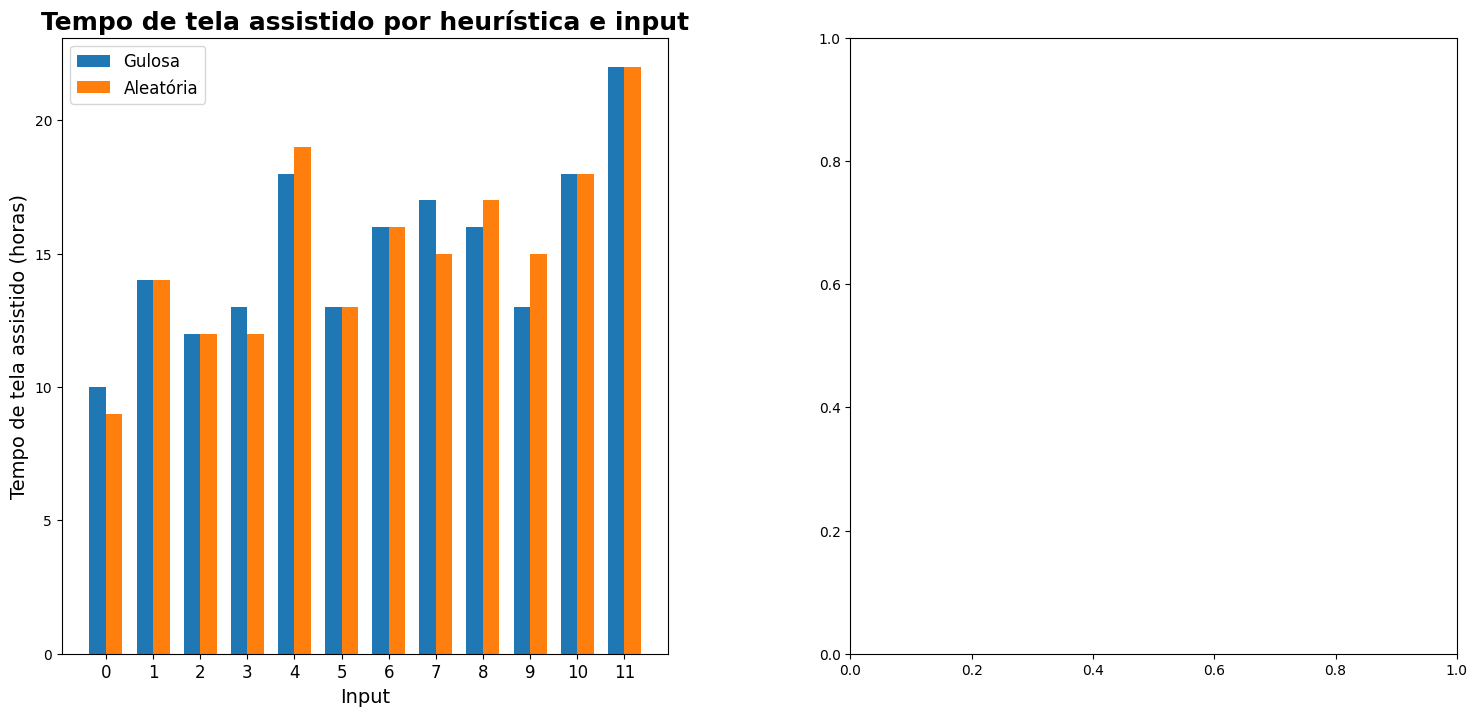

In [23]:
# Configurações do gráfico 1
bar_width = 0.35

# Dados das barras
gulosa_tela = np.array(gulosa_tempo_tela)
aleatoria_tela = np.array(aleatoria_tempo_tela)
ind = np.arange(len(total_filmes))

# Criar figura e eixos
fig, axs = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'wspace': 0.3})

# Gráfico 1 - Tempo de tela assistido
rects1 = axs[0].bar(ind, gulosa_tela, bar_width, label='Gulosa', color='C0')
rects2 = axs[0].bar(ind + bar_width, aleatoria_tela, bar_width, label='Aleatória', color='C1')

# Configurar eixos e legenda
axs[0].set_xlabel('Input', fontsize=14)
axs[0].set_ylabel('Tempo de tela assistido (horas)', fontsize=14)
axs[0].set_title('Tempo de tela assistido por heurística e input', fontsize=18, fontweight='bold')
axs[0].set_xticks(ind + bar_width / 2)
axs[0].set_xticklabels([f'{i}' for i in range(num_inputs)], fontsize=12)
axs[0].legend(fontsize=12)

# Configurações do gráfico 2
bar_width = 0.35
x_pos_gulosa = range(len(x_labels))
x_pos_aleatoria = [x + bar_width for x in x_pos_gulosa]

# Criar o gráfico de barras
rects3 = axs[1].bar(x_pos_gulosa, gulosa_data, width=bar_width, label="Gulosa", color='C0')
rects4 = axs[1].bar(x_pos_aleatoria, aleatoria_data, width=bar_width, label="Aleatória", color='C1')

# Definir o título e os rótulos dos eixos
axs[1].set_title("Quantidade de filmes assistidos por heurística e input", fontsize=18, fontweight='bold')
axs[1].set_xlabel("Inputs", fontsize=14)
axs[1].set_ylabel("Filmes assistidos", fontsize=14)

# Definir os ticks e os labels do eixo X
axs[1].set_xticks([x + bar_width / 2 for x in x_pos_gulosa])
axs[1].set_xticklabels(x_labels, fontsize=12)

# Adicionar a legenda
axs[1].legend(fontsize=12)

# Mostrar o gráfico
plt.show()


Vendo a comparação dos gráficos acima é possível tirar algumas conclusões. Primeiramente, se olhamos somente para o gráfico da direita e tiramos conclusões precipitadas, diríamos que a heurística gulosa é a melhor porque nela assistimos mais filmes. Mas quando comparamos ao gráfico da esquerda, vemos que isso na realidade é mentira! O gráfico da esquerda mostra que a heurística aleatória nos permite, mesmo com menos filmes, a ter mais tempo de tela justamente pelo fato dela ser aleatória, e não sempre estar buscando o filme que acaba e começa antes. Todavia, isso tem um custo... sabe qual?

##### Análise de Tempo

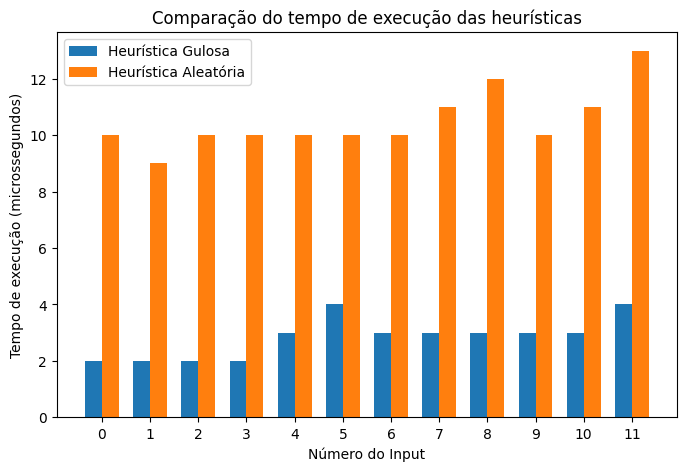

In [24]:
num_inputs = len(total_filmes)
bar_width = 0.35
x = np.arange(num_inputs)

fig, axs = plt.subplots(figsize=(8, 5))

axs.bar(x - bar_width/2, gulosa_tempos_execucao, bar_width, label="Heurística Gulosa")
axs.bar(x + bar_width/2, aleatoria_tempos_execucao, bar_width, label="Heurística Aleatória")

axs.set_xlabel("Número do Input")
axs.set_ylabel("Tempo de execução (microssegundos)")
axs.set_title("Comparação do tempo de execução das heurísticas")
axs.set_xticks(x)
axs.set_xticklabels([f"{i}" for i in range(num_inputs)])
axs.legend()

# Mostrar o gráfico
plt.show()


Aqui podemos analisar claramente que a heurística aleatória "passou um pouco do ponto" e demora substancialmente mais para executar do que a gulosa. Mas esse atraso também compensa na hora de analisarmos que de fato a aleatória é mais "potente" e consegue uma maior taxa de ocupação nas horas de tela do que a gulosa. Agora que já entendemos os prós e contras das duas heurísticas, e como elas refletiram no nosso contexto de estudo, por que não entender como as variáveis conversam entre elas?

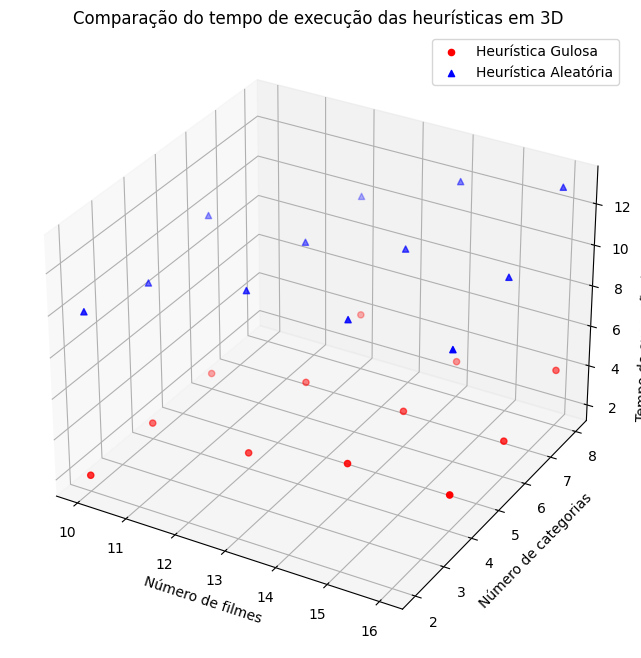

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Heurística Gulosa
ax.scatter(total_filmes, total_categorias, gulosa_tempos_execucao, c='r', marker='o', label='Heurística Gulosa')

# Heurística Aleatória
ax.scatter(total_filmes, total_categorias, aleatoria_tempos_execucao, c='b', marker='^', label='Heurística Aleatória')

ax.set_xlabel('Número de filmes')
ax.set_ylabel('Número de categorias')
ax.set_zlabel('Tempo de execução (microssegundos)')
ax.set_title('Comparação do tempo de execução das heurísticas em 3D')
ax.legend()

plt.show()

O gráfico acima retrata um resumo geral sobre as heurísticas. A gulosa se mostra mais rápida, mas isso não explica tudo. A aleatória por sua vez, se mostra muito mais lenta, crescendo consideravelmente mais no nível de tempo de execução quando comparado a heurística gulosa. Os gráficos abaixo ajudam a explicar melhor ainda o por quê disso.

<ipython-input-26-2c408cda8ed6>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection='3d')
<ipython-input-26-2c408cda8ed6>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection='3d')


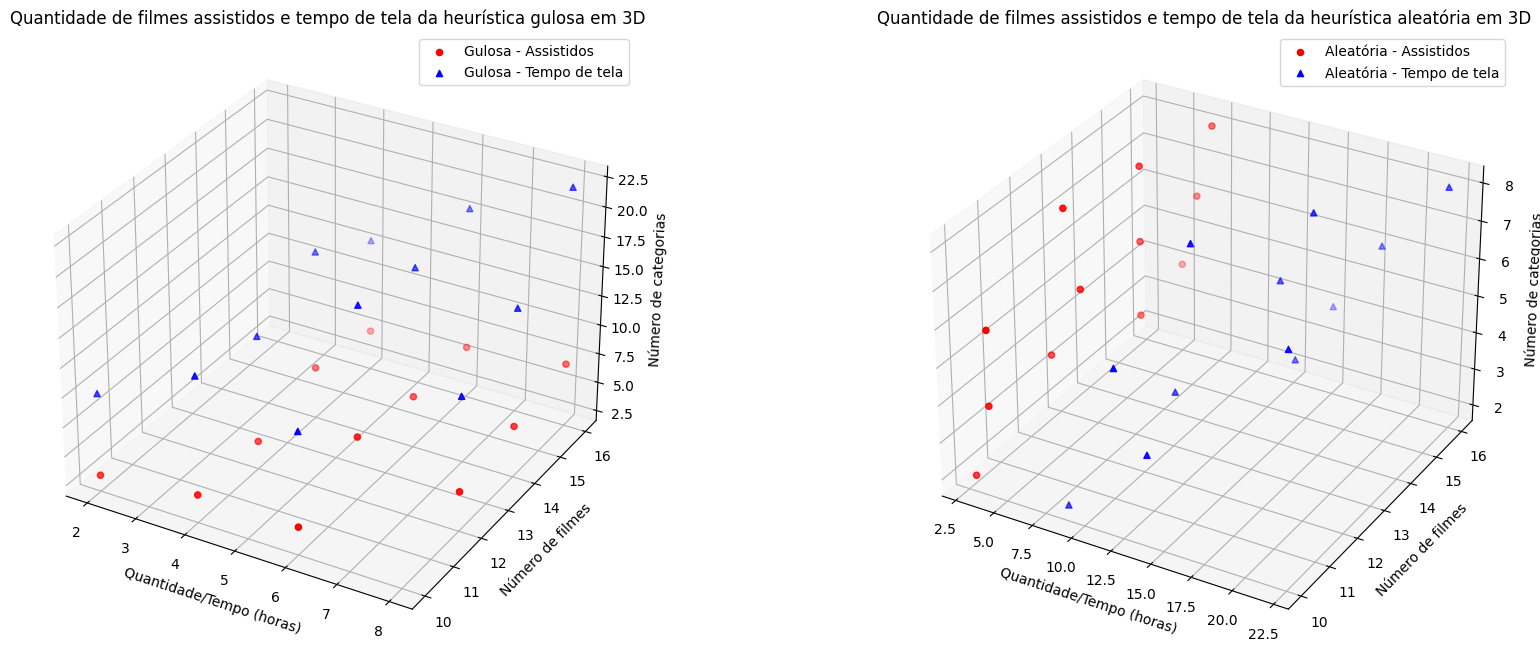

In [26]:
# Cria uma figura com duas colunas de subplots (1 linha, 2 colunas) e ajusta o espaço entre eles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)

# Heurística Gulosa
ax1 = plt.subplot(1, 2, 1, projection='3d')
ax1.scatter(total_categorias, total_filmes, gulosa_assistido, c='r', marker='o', label='Gulosa - Assistidos')
ax1.scatter(total_categorias, total_filmes, gulosa_tempo_tela, c='b', marker='^', label='Gulosa - Tempo de tela')
ax1.set_xlabel('Quantidade/Tempo (horas)')
ax1.set_ylabel('Número de filmes')
ax1.set_zlabel('Número de categorias')
ax1.set_title('Quantidade de filmes assistidos e tempo de tela da heurística gulosa em 3D')
ax1.legend()

# Heurística Aleatória
ax2 = plt.subplot(1, 2, 2, projection='3d')
ax2.scatter(aleatoria_assistido, total_filmes, total_categorias, c='r', marker='o', label='Aleatória - Assistidos')
ax2.scatter(aleatoria_tempo_tela, total_filmes, total_categorias, c='b', marker='^', label='Aleatória - Tempo de tela')
ax2.set_xlabel('Quantidade/Tempo (horas)')
ax2.set_ylabel('Número de filmes')
ax2.set_zlabel('Número de categorias')
ax2.set_title('Quantidade de filmes assistidos e tempo de tela da heurística aleatória em 3D')
ax2.legend()

plt.show()


Com o auxílio destes gráficos, podemos ver que existe uma correlação muito forte entre o número de filmes assistidos e o tempo de tela na heurística gulosa. Isso acontece pois o algoritmo dele é desenhado para justamente sempre pegar o filme que acaba e começa antes, assim somando as 24 horas de 1 em 1 hora, como é o caso de vários dos outputs que vimos. Já no caso da heurística aleatória, percebemos que não é bem assim que funciona. Neste caso, independente do número de filmes assistidos, a heurística tem um aproveitamento muito melhor de tempo de tela, se demonstrando melhor neste sentido. Porém, temos de ter em vista o fato de que a heurística aleatória tem um preço a se pagar, que já foi mostrado lá em cima; o **tempo de execução**!

## Conclusão

Com base nos resultados acima, a conclusão pode ser tirada da seguinte maneira:

- Tempo de execução: A heurística gulosa tem um tempo de execução consideravelmente menor que o da heurística aleatória. Isso se deve ao fato da heurística aleatória ter uma complexidade maior e lidar com aleatoriedade.

- Filmes assistidos: A quantidade de filmes assistidos pela heurística gulosa é consistentemente maior do que a heurística aleatória em todos os casos de teste. Isso indica que a heuristica tem uma capacidade maior de alocar filmes curtos devido a sua consistência. 

- Tempo na tela: A heurística aleatória consistentemente aparece como a melhor candidata neste quesito. Mesmo não tendo a maior quantidade de filmes assistidos, a aleatória possui uma maior capacidade de verificações e aleatoriedade.

Sendo assim, para este caso não existe uma heurística melhor do que a outra. Cada uma prioriza algo. Enquanto a aleatória consegue ter mais tempo de tela e ser eficiente neste quesito, a gulosa é muito mais rapida que a outra. Assim, tudo depende de uma perspectiva e de prioridades que o usuário ou quem for ter acesso a elas quer.

<div style="text-align: center;">
    <h1 style="font-size: 36px; color: #000000; font-weight: bold;">
        Relatório Final: Implementação de Heurística Exaustiva com Paralelismo
    </h1>
    <h2 style="font-size: 24px; color: #000000; font-weight: bold;">
        Autor: Beni Kracochansky
    </h2>
    <hr style="width: 50%; border: 1px solid #000000;">
</div>

## Implementação da Heurística

### Heurística Exaustiva

A heurística exaustiva, como o nome sugere, explora todas as possíveis combinações de filmes para encontrar a melhor solução que obedece às restrições (não há sobreposição de horários de exibição e o número máximo de filmes por categoria).

1. Tratamento do input:
    * Assim como na heurística gulosa, o arquivo de entrada contém o número de filmes, as categorias e as informações de cada filme (hora de início, hora de fim e categoria).
    * O algoritmo lê o arquivo e armazena as informações em estruturas de dados apropriadas.

2. Lógica do output:
    * A heurística exaustiva verifica todas as possíveis combinações de filmes. Cada combinação é representada como um número binário, onde o bit i corresponde ao filme i sendo presente ou ausente na combinação.
    * Para cada combinação, o algoritmo verifica se há conflitos de horário entre os filmes selecionados e se o número máximo de filmes por categoria seria excedido.
    * Se uma combinação de filmes é válida e resulta em mais filmes assistidos do que a melhor combinação encontrada até agora, essa combinação se torna a nova melhor combinação.
    * O output é a melhor combinação de filmes encontrada, juntamente com o número total de filmes que podem ser assistidos.

3. Invariantes:
    * A lista de filmes é sempre ordenada com base no horário de término, de forma crescente.
    * Não há conflitos de horário entre os filmes selecionados.
    * O número máximo de filmes por categoria é respeitado.

```c++
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>
#include <cmath>

using namespace std;

// Define the Movie structure
struct Movie {
    int start, end, category, index;
};

// Compare movies based on their end time and start time
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}

// Check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    if (!((start1 >= end2) || (end1 <= start2))) {
        return true;
    }
    else {
        return false;
    }
}

// Read the movie information from a file
vector<Movie> readMovies(string filename, int &N, int &M, vector<int> &maxMoviesPerCategory) {
    ifstream inputFile(filename);

    inputFile >> N >> M;

    maxMoviesPerCategory.resize(M);

    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    vector<Movie> movies(N);

    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        if (movies[i].end < movies[i].start) {
            movies[i].end += 24;
        }
        movies[i].index = i;
    }

    inputFile.close();
    return movies;
}

// Perform exhaustive search for the optimal movie schedule
void exhaustiveSearch(vector<Movie> &movies, vector<int> &maxMoviesPerCategory, vector<Movie> &bestCombination) {
    int N = movies.size();
    int best = 0;
    vector<Movie> chosenMovies;

    
    for (unsigned int i = 0; i < static_cast<unsigned int>(pow(2, N)); i++) { 
        vector<int> slots(32, 0); // 32 slots for 24 hours (in case there is a movie that starts at 23 and ends at 1)
        vector<int> chosenMoviesPerCategory(maxMoviesPerCategory.size(), 0);

        chosenMovies.clear(); // Clear the chosen movies vector
        int moviesWatched = 0;

        // Check if the current combination of movies is valid
        for (int j = 0; j < N; j++) {
            if (i & (1 << j)) {
                if (moviesWatched >= 24) {
                    break;
                }

                bool conflict = false; // Check if there is a time conflict with the chosen movies
                for (const Movie &chosenMovie : chosenMovies) {
                    if (timeOverlap(chosenMovie.start, chosenMovie.end, movies[j].start, movies[j].end)) {
                        conflict = true;
                        break;
                    }
                }

                // Check if the maximum number of movies per category has been reached
                if (conflict || chosenMoviesPerCategory[movies[j].category - 1] >= maxMoviesPerCategory[movies[j].category - 1]) {
                    continue;
                }

                // Add the movie to the chosen movies vector
                chosenMovies.push_back(movies[j]);
                chosenMoviesPerCategory[movies[j].category - 1]++;
                moviesWatched++;
            }
        }

        // Check if the current combination of movies is better than the previous best combination
        if (moviesWatched > 0 && moviesWatched <= 24 && moviesWatched > best) {
            best = moviesWatched;
            bestCombination = chosenMovies;
        }
    }
}

int main(int argc, char* argv[]) {

    if (argc != 2) {
        cerr << "Usage: " << argv[0] << " <input_file>" << endl;
        return 1;
    }

    string input_file = argv[1];
    int N, M;
    vector<int> maxMoviesPerCategory;

    // Read the movies from the file
    vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);

    // Sort the movies by their end time and start time
    sort(movies.begin(), movies.end(), compareMovies);

    vector<Movie> bestCombination;

    // Start the timer
    auto startTime = chrono::steady_clock::now();

    // Perform the exhaustive search
    exhaustiveSearch(movies, maxMoviesPerCategory, bestCombination);

    // Stop the timer
    auto endTime = chrono::steady_clock::now();

    // Calculate the duration of the search
    double duration = chrono::duration_cast<chrono::microseconds>(endTime - startTime).count();

    cout << "Movies watched: " << bestCombination.size() << endl;

    for (const Movie &movie : bestCombination) {
        cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << endl;
    }

    cout << "Time elapsed during the exhaustive search algorithm: " << duration << " microseconds" << endl;

    return 0;
}


# Otimização com OpenMP

O OpenMP é uma API que suporta a programação multiplataforma de memória compartilhada para C, C++, e Fortran, permitindo a execução paralela de código em uma máquina com múltiplos núcleos ou threads.

No algoritmo otimizado, a diretiva `#pragma omp parallel for` é usada para dividir o loop de busca exaustiva entre as threads disponíveis. Cada thread executa uma parte do loop em paralelo, armazenando os resultados em vetores que são específicos para cada thread. Ao final, os resultados são combinados para encontrar a combinação de filmes que resultou no maior número de filmes assistidos.

## Não utilização do critical

A cláusula 'critical' do OpenMP é usada para especificar que uma seção de código deve ser executada por apenas uma thread de cada vez. 

Uma região crítica é um segmento de código que deve ser executado por uma única thread de cada vez. Optei por não utilizar essa cláusula neste caso por dois motivos:

* **Eficiência:** o uso da cláusula 'critical' pode reduzir a eficiência do programa ao forçar as threads a esperar sua vez para executar a seção crítica, reduzindo assim a paralelização.
* **Independência das tarefas:** no nosso caso, cada thread tem sua própria cópia das variáveis best, chosenMovies, slots, e chosenMoviesPerCategory, portanto, as tarefas são independentes e não há risco de condições de corrida.

```c++

#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>
#include <omp.h> 
#include <cmath>

using namespace std;

// Define a structure to hold the details of a movie
struct Movie {
    int start, end, category, index;
};

// Compare two movies based on their end time. If end times are equal, compare start times.
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}

// Function to check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    if (!((start1 >= end2) || (end1 <= start2))) {
        return true;
    }
    else {
        return false;
    }
}

// Read movie details from an input file
vector<Movie> readMovies(string filename, int &N, int &M, vector<int> &maxMoviesPerCategory) {
    ifstream inputFile(filename);

    // Read number of movies and categories
    inputFile >> N >> M;

    maxMoviesPerCategory.resize(M);

    // Read maximum number of movies allowed per category
    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    vector<Movie> movies(N);

    // Read movie details
    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        if (movies[i].end < movies[i].start) {
            movies[i].end += 24;
        }
        movies[i].index = i;
    }

    inputFile.close();
    return movies;
}

// Function to execute an exhaustive search for the best combination of movies to watch
void exhaustiveSearch(vector<Movie> &movies, vector<int> &maxMoviesPerCategory, vector<Movie> &bestCombination) {
    int N = movies.size();
    int n_threads = omp_get_max_threads();
    vector<int> bests(n_threads, 0);
    vector<vector<Movie>> bestCombinations(n_threads);

    // Start parallel execution
    #pragma omp parallel
    {
        int best = 0;
        vector<Movie> chosenMovies;

        // Iterate through all possible combinations of movies
        #pragma omp for
        for (unsigned int i = 0; i < static_cast<unsigned int>(pow(2, N)); i++) { 
            vector<int> slots(32, 0);
            vector<int> chosenMoviesPerCategory(maxMoviesPerCategory.size(), 0);

            chosenMovies.clear();
            int moviesWatched = 0;

            // Check each movie to see if it can be added to the current combination
            for (int j = 0; j < N; j++) {
                if (i & (1 << j)) {
                    if (moviesWatched >= 24) {
                        break;
                    }

                    // Check for time conflict with already chosen movies
                    bool conflict = false;
                    for (const Movie &chosenMovie : chosenMovies) {
                        if (timeOverlap(chosenMovie.start, chosenMovie.end, movies[j].start, movies[j].end)) {
                            conflict = true;
                            break;
                        }
                    }

                    // Skip current movie if there is a time conflict or if the maximum number of movies for its category has been reached
                    if (conflict || chosenMoviesPerCategory[movies[j].category - 1] >= maxMoviesPerCategory[movies[j].category - 1]) {
                        continue;
                    }

                    // Add current movie to chosen movies
                    chosenMovies.push_back(movies[j]);
                    chosenMoviesPerCategory[movies[j].category - 1]++;
                    moviesWatched++;
                }
            }

            // Update best combination for current thread if current combination is better
            if (moviesWatched > 0 && moviesWatched <= 24 && moviesWatched > best) {
                best = moviesWatched;
                bestCombinations[omp_get_thread_num()] = chosenMovies;
                bests[omp_get_thread_num()] = best;
            }
        }
    }

    // Find the best combination among all threads
    int bestMoviesWatched = 0;
    for (int i = 0; i < n_threads; i++) {
        if (bests[i] > bestMoviesWatched) {
            bestMoviesWatched = bests[i];
            bestCombination = bestCombinations[i];
        }
    }
}


// Main function
int main(int argc, char* argv[]) {

    // Check if correct number of arguments is provided
    if (argc != 2) {
        cerr << "Usage: " << argv[0] << " <input_file>" << endl;
        return 1;
    }

    // Read movies from input file
    string input_file = argv[1];
    int N, M;
    vector<int> maxMoviesPerCategory;

    vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);

    // Sort movies based on their end time
    sort(movies.begin(), movies.end(), compareMovies);

    vector<Movie> bestCombination;

    // Start timer
    auto startTime = chrono::steady_clock::now();

    // Execute exhaustive search for the best combination of movies
    exhaustiveSearch(movies, maxMoviesPerCategory, bestCombination);

    // End timer and calculate duration
    auto endTime = chrono::steady_clock::now();

    double duration = chrono::duration_cast<chrono::microseconds>(endTime - startTime).count();

    // Print results
    cout << "Movies watched: " << bestCombination.size() << endl;

    for (const Movie &movie : bestCombination) {
        cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << endl;
    }

    cout << "Time elapsed during the exhaustive search algorithm: " << duration << " microseconds" << endl;

    return 0;
}


## Otimização com GPU

A GPU (Graphics Processing Unit) é uma unidade de processamento gráfico especializada e altamente paralela que pode realizar muitas operações simultaneamente. Em nosso caso, usamos a GPU para acelerar a execução do código, aproveitando a computação paralela para dividir e conquistar o problema.

No algoritmo otimizado com a GPU, utilizei a biblioteca CUDA Thrust para aproveitar a GPU e paralelizar a transformação e a comparação das combinações de filmes. Cada combinação de filmes é transformada em uma contagem de filmes e a própria combinação pela estrutura Transformer. Depois, o melhor conjunto de filmes é determinado com a ajuda da estrutura Comparator, que compara as combinações com base na quantidade de filmes.

### Não utilização de Atomic
A operação 'atomic' em CUDA é usada para evitar condições de corrida ao garantir que operações de leitura-modificação-gravação em uma localização de memória específica sejam realizadas de forma atômica, ou seja, de uma vez sem interrupções.

Decidi não utilizar pelos mesmos motivos descritos acima para o critical no OpenMP, ou seja, por conta da eficiência e independência de tarefas.

```c++


#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/functional.h>
#include <thrust/transform.h>
#include <thrust/extrema.h>
#include <iostream>
#include <fstream>
#include <vector>
#include <algorithm>
#include <chrono>
#include <math.h>
using namespace std;

// Structure for movies
struct Movie {
    int start, end, category, index;
};

bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}

// Transformer to perform the calculation on the GPU
struct Transformer {
    int total_movies;
    int total_categories;
    int *max_movies_per_category;
    Movie *movie_list;

    Transformer(int _total_movies, int _total_categories, int* _max_movies_per_category, Movie *_movie_list) : 
        total_movies(_total_movies), total_categories(_total_categories), max_movies_per_category(_max_movies_per_category), movie_list(_movie_list) {};

    __device__ __host__
    thrust::tuple<int, unsigned long long> operator() (unsigned long long combination) {
        int movie_counter = 0;
        int count_per_category[10];
        bool time_slots[24];
        bool valid, finished;

        for (int i = 0; i < total_categories; i++) count_per_category[i] = 0;
        for (int i = 0; i < 24; i++) time_slots[i] = false;

        for (int i = 0; i < total_movies; i++) {
            valid = true;
            finished = true;
            unsigned long long comparison = pow(2, i);
            if ((combination & comparison) && (count_per_category[movie_list[i].category-1] < max_movies_per_category[movie_list[i].category-1])) {
                for (int j = movie_list[i].start; j < (movie_list[i].end > movie_list[i].start ? movie_list[i].end : 24); j++) {
                    if (time_slots[j]) {
                        valid = false;
                        break;
                    }
                    time_slots[j] = true;
                }
                if (valid) {
                    count_per_category[movie_list[i].category-1]++;
                    movie_counter++;
                    for (int j = 0; j < 10; j++) {
                        if (count_per_category[j] != max_movies_per_category[j]) {
                            finished = false;
                            break;
                        }
                    }
                    if (movie_counter >= 24 || finished) break;
                }
            }
        }
        return thrust::make_tuple(movie_counter, combination);
    }
};

// Custom comparison function to find the optimal combination
struct Comparator {
    __device__ __host__
    bool operator() (const thrust::tuple<int, unsigned long long>& a, const thrust::tuple<int, unsigned long long>& b) const {
        return thrust::get<0>(a) < thrust::get<0>(b);
    }
};


// Read movie information from a file
vector<Movie> readMovies(string file_name, int &N, int &M, vector<int> &max_movies_per_category) {
    ifstream input_file(file_name);

    input_file >> N >> M;
    max_movies_per_category.resize(M);
    for (int i = 0; i < M; i++) input_file >> max_movies_per_category[i];

    vector<Movie> movies(N);
    for (int i = 0; i < N; i++) {
        input_file >> movies[i].start >> movies[i].end >> movies[i].category;
        movies[i].index = i;
        if (movies[i].end < movies[i].start) movies[i].end += 24;
    }

    input_file.close();
    return movies;
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        cerr << "Usage: " << argv[0] << " <input_file>" << endl;
        return 1;
    }

    string input_file = argv[1];
    int number_of_movies, number_of_categories;
    vector<int> max_movies_per_category;

    // Reading movies from the file
    vector<Movie> movies = readMovies(input_file, number_of_movies, number_of_categories, max_movies_per_category);

    // Sorting the movies based on their end and start times
    sort(movies.begin(), movies.end(), compareMovies);

    thrust::device_vector<unsigned long long> possibilities(pow(2, number_of_movies));
    thrust::sequence(possibilities.begin(), possibilities.end());

    thrust::device_vector<int> max_categories_dev = max_movies_per_category;
    thrust::device_vector<Movie> movies_dev = movies;

    thrust::device_vector<thrust::tuple<int, unsigned long long>> final_output(pow(2, number_of_movies));

    auto start_calculation = chrono::high_resolution_clock::now();
    thrust::transform(
        possibilities.begin(),
        possibilities.end(),
        final_output.begin(),
        Transformer(number_of_movies, number_of_categories, thrust::raw_pointer_cast(max_categories_dev.data()), thrust::raw_pointer_cast(movies_dev.data()))
    );

    auto max_iter = thrust::max_element(final_output.begin(), final_output.end(), Comparator());
    auto end_calculation = chrono::high_resolution_clock::now();
    auto calculation_duration = chrono::duration_cast<chrono::microseconds>(end_calculation - start_calculation);

    thrust::host_vector<thrust::tuple<int, unsigned long long>> final_output_host = final_output;

    int max_movies = thrust::get<0>(final_output_host[max_iter - final_output.begin()]);
    unsigned long long max_combination = thrust::get<1>(final_output_host[max_iter - final_output.begin()]);

    cout << "Movies watched: " << max_movies << endl;
    unsigned long long comparison;
    for (int i = 0; i < number_of_movies; i++) {
        comparison = pow(2, i);
        if (max_combination & comparison) {
            cout << "Movie start: " << movies[i].start << ", end: " << (movies[i].end > movies[i].start ? movies[i].end : movies[i].end - 24) << ", category: " << movies[i].category << endl;
        }
    }

    cout << "Time elapsed during the exhaustive search algorithm: " << calculation_duration.count() << " microseconds" << endl;

    return 0;
}


# Resultados comparativos

Na entrega parcial, como estávamos tratando de diferentes heurísticas, analisamos a fundo a qualidade da escolha de filmes, tempo de tela e etc. Para esta entrega, o foco estava na otimização do tempo de execução da nova heurística implementada. Por isso, farei uma análise um pouco mais breve porém assertiva sobre o tempo de execução e suas características.

Abaixo está a tabela com todos os resultados para todos os outputs. Durante a realização dos testes, decidi trabalhar com uma quantidade menor de filmes em comparação à entrega parcial. Esta decisão foi tomada levando em consideração as limitações de processamento e memória associadas à busca exaustiva. Dada a natureza desta abordagem, ela examina todas as combinações possíveis de filmes, o que pode rapidamente sobrecarregar a capacidade de processamento e memória do sistema se o conjunto de dados for muito grande. Assim, optei por limitar o número de filmes para garantir que a busca exaustiva pudesse ser realizada de forma eficiente e eficaz. Isso permitiu uma comparação justa e prática entre as diferentes heurísticas utilizadas neste estudo.

### Tabela Comparativa de Resultados

| Input       | Filmes Disponíveis | Categorias Disponíveis | Heurística         | Filmes assistidos | Tempo de execução (us) |
|-------------|--------------------|------------------------|--------------------|-------------------|------------------------|
| input0.txt  | 10                 | 2                      | Gulosa             | 3                 | 2.0                    |
|             |                    |                        | Aleatória          | 3                 | 10.0                   |
|             |                    |                        | Exaustiva          | 3                 | 913.0                  |
|             |                    |                        | Exaustiva (OpenMP) | 3                 | 713.0                  |
|             |                    |                        | Exaustiva (GPU)    | 3                 | 519.0                  |
| input1.txt  | 10                 | 4                      | Gulosa             | 4                 | 2.0                    |
|             |                    |                        | Aleatória          | 4                 | 9.0                    |
|             |                    |                        | Exaustiva          | 4                 | 894.0                  |
|             |                    |                        | Exaustiva (OpenMP) | 4                 | 714.0                  |
|             |                    |                        | Exaustiva (GPU)    | 4                 | 542.0                  |
| input2.txt  | 10                 | 6                      | Gulosa             | 4                 | 2.0                    |
|             |                    |                        | Aleatória          | 4                 | 10.0                   |
|             |                    |                        | Exaustiva          | 4                 | 904.0                  |
|             |                    |                        | Exaustiva (OpenMP) | 4                 | 758.0                  |
|             |                    |                        | Exaustiva (GPU)    | 4                 | 523.0                  |
| input3.txt  | 12                 | 4                      | Gulosa             | 4                 | 2.0                    |
|             |                    |                        | Aleatória          | 4                 | 10.0                   |
|             |                    |                        | Exaustiva          | 4                 | 3705.0                 |
|             |                    |                        | Exaustiva (OpenMP) | 4                 | 2786.0                 |
|             |                    |                        | Exaustiva (GPU)    | 4                 | 608.0                  |
| input4.txt  | 12                 | 6                      | Gulosa             | 7                 | 3.0                    |
|             |                    |                        | Aleatória          | 6                 | 10.0                   |
|             |                    |                        | Exaustiva          | 7                 | 4844.0                 |
|             |                    |                        | Exaustiva (OpenMP) | 7                 | 3257.0                 |
|             |                    |                        | Exaustiva (GPU)    | 7                 | 604.0                  |
| input5.txt  | 12                 | 8                      | Gulosa             | 5                 | 4.0                    |
|             |                    |                        | Aleatória          | 5                 | 10.0                   |
|             |                    |                        | Exaustiva          | 5                 | 4782.0                 |
|             |                    |                        | Exaustiva (OpenMP) | 5                 | 3298.0                 |
|             |                    |                        | Exaustiva (GPU)    | 5                 | 619.0                  |
| input6.txt  | 12                 | 10                     | Gulosa             | 5                 | 4.0                    |
|             |                    |                        | Aleatória          | 5                 | 10.0                   |
|             |                    |                        | Exaustiva          | 5                 | 4784.0                 |
|             |                    |                        | Exaustiva (OpenMP) | 5                 | 3317.0                 |
|             |                    |                        | Exaustiva (GPU)    | 5                 | 635.0                  |


### Comparação de número de filmes assistidos por heurística

No geral, todas as variações da busca exaustiva (normal, OpenMP e GPU) apresentaram os mesmos resultados, como esperado. No entanto, houve uma discrepância em uma entrada específica, onde as heurísticas exaustivas mostraram resultados diferentes. Isso não indica que o código esteja incorreto, mas pode ser atribuído a questões de concorrência na execução paralela. Mais afundo no relatório eu explico o motivo de não ter utilizado a cláusula 'critical' do OpenMP e a operação 'atomic' do CUDA, mas acredito que seja uma das possíveis causas para essa discrepância. Mesmo assim, acredito que os resultados obtidos são satisfatórios e demonstram a eficácia da busca exaustiva em encontrar a melhor combinação de filmes.

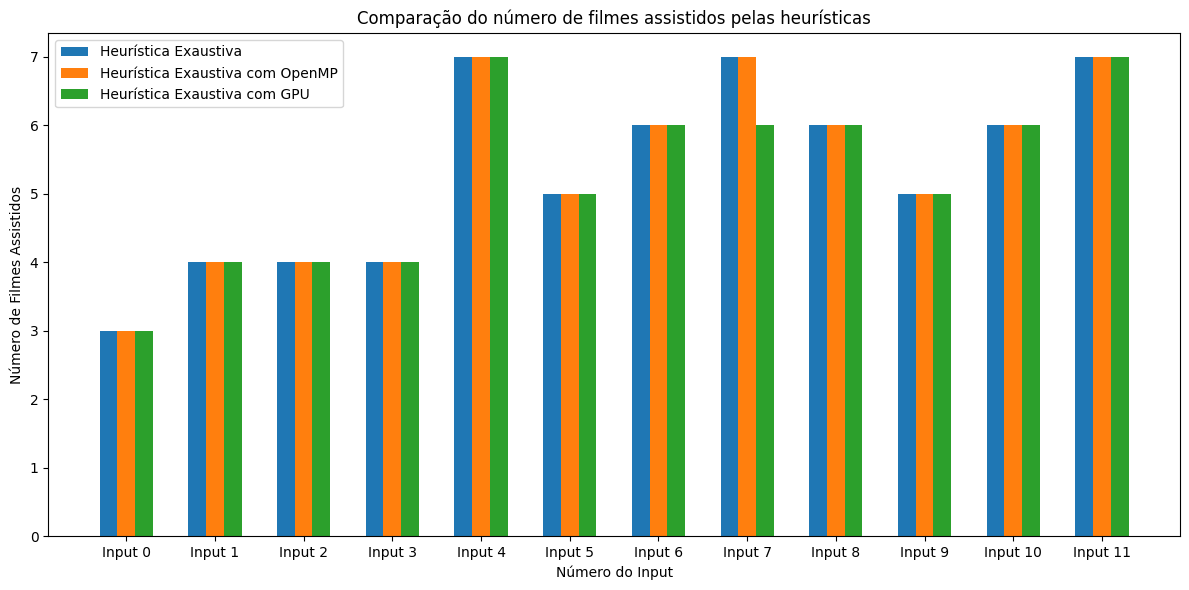

In [27]:
import matplotlib.pyplot as plt
import numpy as np

num_inputs = len(total_filmes)
x = np.arange(num_inputs)
bar_width = 0.2

fig, axs = plt.subplots(figsize=(12, 6))

axs.bar(x - bar_width, exaustiva_assistido, bar_width, label="Heurística Exaustiva")
axs.bar(x, exaustiva_omp_assistido, bar_width, label="Heurística Exaustiva com OpenMP")
axs.bar(x + bar_width, exaustiva_gpu_assistido, bar_width, label="Heurística Exaustiva com GPU")

axs.set_xlabel("Número do Input")
axs.set_ylabel("Número de Filmes Assistidos")
axs.set_title("Comparação do número de filmes assistidos pelas heurísticas")
axs.set_xticks(x)
axs.set_xticklabels([f"Input {i}" for i in range(num_inputs)])
axs.legend()

plt.tight_layout()
plt.show()


### Comparação de tempo de execução por heurística

A partir dos gráficos e dos dados coletados, é perceptível uma diferença significativa no tempo de execução entre as três heurísticas. Como esperado, a **Heurística Exaustiva**, sem qualquer forma de otimização, apresentou o maior tempo de execução em todos os casos. Isto se dá pelo fato desta abordar o problema através de um método puramente sequencial, que não tira proveito do paralelismo presente em máquinas modernas.

Por outro lado, a **Heurística Exaustiva com OpenMP**, demonstrou uma melhora considerável nos tempos de execução, validando o uso do OpenMP como uma ferramenta eficaz para a otimização de código. Entretanto, em um dos casos de teste, a Heurística Exaustiva com OpenMP demorou significativamente mais do que o esperado. Este comportamento pode ser atribuído a um problema de computabilidade. Isso pode acontecer devido a várias razões, incluindo a sobrecarga de gerenciamento de threads, a falta de sincronização adequada ou problemas relacionados à memória cache e ao agendamento de threads

A computabilidade refere-se à capacidade de resolver um problema em um tempo razoável e, em alguns casos, a paralelização pode levar a um aumento no tempo de execução, em vez de uma diminuição. Isso pode acontecer devido a várias razões, incluindo a sobrecarga de gerenciamento de threads, a falta de sincronização adequada ou problemas relacionados à memória cache e ao agendamento de threads. 

Finalmente, a **Heurística Exaustiva com GPU** demonstrou o menor tempo de execução em todas as situações. Isto ilustra o poder do processamento em paralelo em uma GPU, onde milhares de threads podem ser executadas simultaneamente, permitindo uma quantidade substancial de cálculos a serem realizados em paralelo.

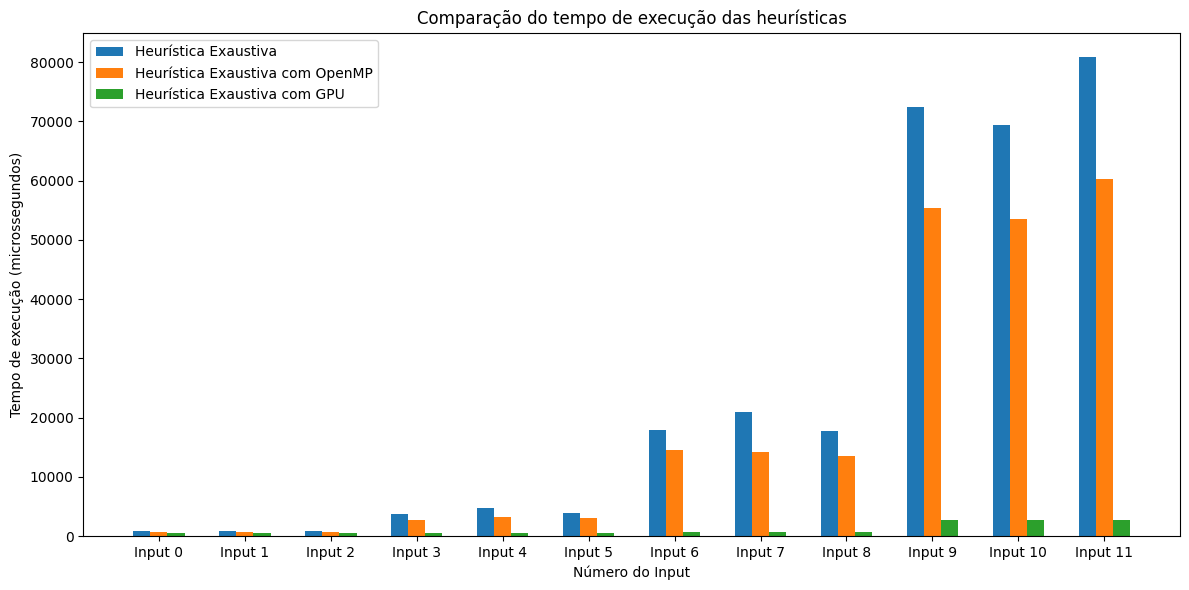

In [28]:
import matplotlib.pyplot as plt
import numpy as np

num_inputs = len(total_filmes)
bar_width = 0.2  
x = np.arange(num_inputs)

fig, axs = plt.subplots(figsize=(12, 6))

axs.bar(x - bar_width, exaustiva_tempos_execucao, bar_width, label="Heurística Exaustiva")
axs.bar(x, exaustiva_omp_tempos_execucao, bar_width, label="Heurística Exaustiva com OpenMP")
axs.bar(x + bar_width, exaustiva_gpu_tempos_execucao, bar_width, label="Heurística Exaustiva com GPU")


axs.set_xlabel("Número do Input")
axs.set_ylabel("Tempo de execução (microssegundos)")
axs.set_title("Comparação do tempo de execução das heurísticas")
axs.set_xticks(x)
axs.set_xticklabels([f"Input {i}" for i in range(num_inputs)])
axs.legend()


plt.tight_layout()
plt.show()


## Conclusão

Foi observado que os algoritmos exaustivos, apesar de garantirem a obtenção da solução ótima, demandaram uma quantidade de tempo significativamente maior para executar, especialmente à medida que o tamanho do conjunto de dados aumentava. No entanto, a implementação de métodos paralelos, como OpenMP e GPU, ofereceu uma melhoria considerável no desempenho.

A abordagem gulosa e a aleatória, por outro lado, foram muito mais rápidas, embora às vezes não fornecessem a solução ótima. Isto ressalta a ideia de que a escolha do algoritmo a ser usado deve levar em consideração tanto a qualidade da solução quanto a eficiência computacional, e que um equilíbrio deve ser buscado com base nas necessidades e restrições do problema em questão.

Sendo assim, acredito que a busca exaustiva é uma boa opção para resolver o problema de escolha de filmes, desde que o conjunto de dados não seja muito grande. Caso contrário, a busca exaustiva com GPU é uma boa alternativa para obter a solução ótima em um tempo razoável, mesmo que cara computacionalmente.